In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import sys
import tqdm
import gc
import lightgbm as lgb
import argparse
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error

## I. Read data

In [2]:
train = pd.read_csv('dataset\\train.csv')
test = pd.read_csv('dataset\\test.csv')
train.info()
id_list = set(train['id'].tolist())
dt_list = set(train['dt'].tolist())
id_list = list(id_list)
print(len(id_list))
print(len(dt_list))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2877305 entries, 0 to 2877304
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      object 
 1   dt      int64  
 2   type    int64  
 3   target  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 87.8+ MB
5832
496


In [3]:
train.head(3)

,id,dt,type,target
0,00037f39cf,11,2,44.050
1,00037f39cf,12,2,50.672
2,00037f39cf,13,2,39.042


In [4]:
test.head(3)

,id,dt,type
0,00037f39cf,1,2
1,00037f39cf,2,2
2,00037f39cf,3,2


## II. Visualization


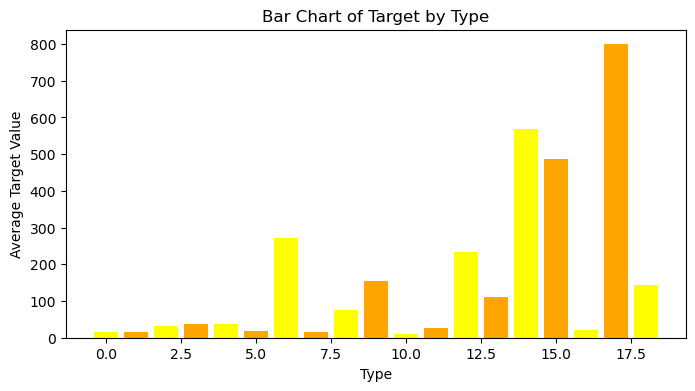

In [5]:
type_target_df = train.groupby('type')['target'].mean().reset_index()
plt.figure(figsize=(8, 4))
plt.bar(type_target_df['type'], type_target_df['target'], color=['yellow', 'orange'])
plt.xlabel('Type')
plt.ylabel('Average Target Value')
plt.title('Bar Chart of Target by Type')
%matplotlib inline

Text(0.5, 1.0, "Line Chart of Target for ID '00037f39cf'")

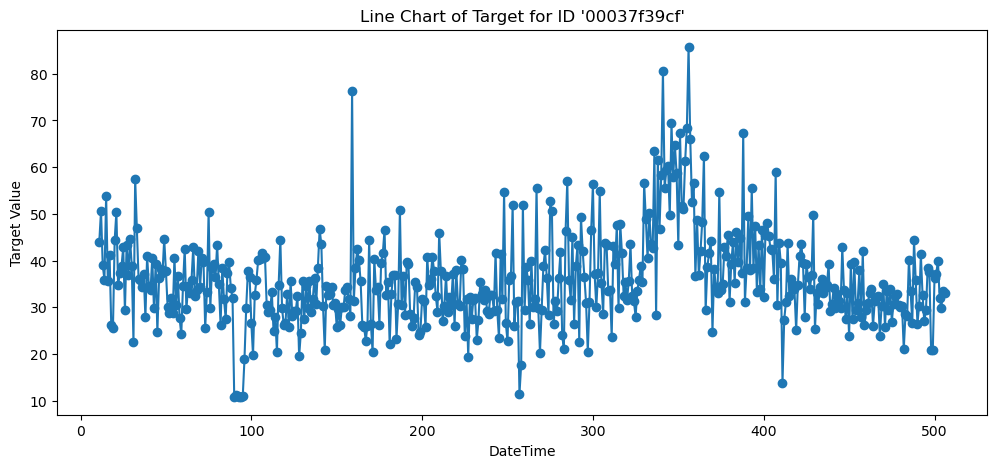

In [6]:
specific_id_df = train[train['id'] == '00037f39cf']
plt.figure(figsize=(12, 5))
plt.plot(specific_id_df['dt'], specific_id_df['target'], marker='o', linestyle='-')
plt.xlabel('DateTime')
plt.ylabel('Target Value')
plt.title("Line Chart of Target for ID '00037f39cf'")

## III. Feature Processing

In [7]:
# concat and sort
data = pd.concat([test, train], axis=0, ignore_index=True)
data = data.sort_values(['id', 'dt'], ascending=False).reset_index(drop=True)

# 历史平移
for i in range(10, 30):
    data[f'last{i}_target'] = data.groupby(['id'])['target'].shift(i)

# 窗口统计
data[f'win3_mean_target'] = (data['last10_target'] + data['last11_target'] + data['last12_target']) / 3

# data.head(15)

train = data[data.target.notnull()].reset_index(drop=True)
test = data[data.target.isnull()].reset_index(drop=True)

# test.head(10)

train_cols = [f for f in data.columns if f not in ['id', 'target']]

## IV. Model Training

In [8]:
# version: 1.0 
# model: lgb
# p.s. baseline of datawhale using lightgbm as the model merely

def time_model(lgb, train_df, test_df, cols):

    # split train_set & test(val)_set
    trn_x, trn_y = train_df[train_df.dt>=31][cols], train_df[train_df.dt>=31]['target']
    val_x, val_y = train_df[train_df.dt<=30][cols], train_df[train_df.dt<=30]['target']

    # build input
    train_matrix = lgb.Dataset(trn_x, label=trn_y)
    valid_matrix = lgb.Dataset(val_x, label=val_y)

    # set parameters of lgb
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mse',
        'min_child_weight': 5, # higher => more conservative, avoid overfitting
        'num_leaves': 2 ** 5, # higher => more precise, may cause overfitting
        'lambda_l2': 10,
        'feature_fraction': 0.8, # rate of sampling featrues
        'bagging_fraction': 0.8, # rate of sampling data
        'bagging_freq': 4, # bagging frequency
        'learning_rate': 0.05,
        'seed': 2024,
        'nthread': 16, # the usage of the cores
        'verbose': -1, # display of info of training-(-1 means without display)
    }

    # train the model
    from lightgbm.callback import log_evaluation
    model = lgb.train(lgb_params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix],
                      callbacks=[log_evaluation(period=100)])
    
    # prediction
    val_pred = model.predict(val_x, num_iteration=model.best_iteration)
    test_pred = model.predict(test_df[cols], num_iteration=model.best_iteration)

    # off-line evaluation
    score = mean_squared_error(val_pred, val_y)
    print(score)

    return val_pred, test_pred    
    

In [9]:
lgb_oof, lgb_test = time_model(lgb, train, test, train_cols)

[100]	training's l2: 210.044	valid_1's l2: 206.64
[200]	training's l2: 195.919	valid_1's l2: 191.972
[300]	training's l2: 189.863	valid_1's l2: 188.501
[400]	training's l2: 185.481	valid_1's l2: 186.52
[500]	training's l2: 181.756	valid_1's l2: 185.823
[600]	training's l2: 179.144	valid_1's l2: 184.535
[700]	training's l2: 176.348	valid_1's l2: 184.045
[800]	training's l2: 174.323	valid_1's l2: 183.853
[900]	training's l2: 172.479	valid_1's l2: 183.676
[1000]	training's l2: 170.758	valid_1's l2: 183.92
[1100]	training's l2: 169.253	valid_1's l2: 183.98
[1200]	training's l2: 167.804	valid_1's l2: 184.309
[1300]	training's l2: 166.52	valid_1's l2: 184.34
[1400]	training's l2: 165.349	valid_1's l2: 184.526
[1500]	training's l2: 164.088	valid_1's l2: 184.673
[1600]	training's l2: 163.125	valid_1's l2: 184.534
[1700]	training's l2: 162.029	valid_1's l2: 184.503
[1800]	training's l2: 160.996	valid_1's l2: 184.608
[1900]	training's l2: 160.142	valid_1's l2: 184.647
[2000]	training's l2: 159.3

In [10]:
test['target'] = lgb_test
test[['id', 'dt', 'target']].to_csv('submit1.csv', index=None)